Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [111]:
# Imports

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor, XGBClassifier

In [145]:
# Wrangle Data

pd.set_option('display.max_rows', 150)

def readIn(file, parse_d='DATE', idx='DATE'):
    """ Opens .csv file, creates datetime index, and returns DataFrame"""

    DATA_PATH = '../data/build_finance/'
    df = pd.read_csv(DATA_PATH+file,
                     parse_dates=[parse_d]).set_index(idx)
    return df


def manyToOne(files_m, files_q, file_w):
    """Accepts lists of .csv files and returns single DataFrame"""

    # Takes monthly and quarterly files, has them read_in, parses their
    # dates, and return DataFrames held in lists
    frames_m = [readIn(file) for file in files_m]
    frames_q = [readIn(file) for file in files_q]

    # Reads in SP500 data, indicates columns to use, and capitalizes 'DATE'
    # for consistency with other DataFrames held in frames_m and frames_q
    DATA_PATH = '../data/build_finance/'
    sp = pd.read_csv(DATA_PATH+file_w, usecols=['Date', 'Close'],
                     parse_dates=['Date']).set_index('Date')
    sp.rename(columns={'Date': 'DATE', 'Close': 'SP500_CLOSE'}, inplace=True)

    # Concatenate DataFrames held in frames_m and frames_q
    concat_m = pd.concat(frames_m, axis=1)
    concat_q = pd.concat(frames_q, axis=1)

    # Final concatenation of all DataFrames (monthly data, quarterly data 
    # and SP500 data)
    last = pd.concat([concat_m, concat_q, sp], axis=1)

    # SP500 data is only available from 1/1/1985
    # Mask out dates prior to January 1st, 1985
    mask = last.index >= '1985-01-01'
    df_final = last[mask]
    df_final.shape

    # Return DataFrame
    return df_final


def wrangle(files_m, files_q, file_w):
    # Pass .csv files and have a single DataFrame returned
    df = manyToOne(files_m, files_q, file_w)

    # Rename columns
    df.columns = ['cpi', '10yr_treasury', 'housing_starts', 
                  'industrial_prod', 'initial_claims', 'unemployment_rate', 
                  'corp_profits', 'exports_goods_svs', 'gdp', 'net_exports',
                  'sp500_close']

    # Reorganize columns
    cols_reorder = ['corp_profits', 'exports_goods_svs', 'net_exports', 
                    'gdp', '10yr_treasury', 'cpi', 'industrial_prod', 
                    'unemployment_rate', 'initial_claims', 'housing_starts', 
                    'sp500_close']

    df = df.reindex(columns=cols_reorder)

    # Create a target feature, month-ahead-return: positive/negative - 
    # Binary Classification
    #df['sp_ahead'] = df['sp500_close'].shift(-1)
    df['sp_ahead_pos_neg'] = (df['sp500_close'].shift(-1) - df['sp500_close']) > 0

    # Drop leaky feature
    df.drop(columns='sp500_close', inplace=True)

    # Forward fill the quarterly data
    df.ffill(inplace=True)

    # Create new feature the shows the montly change in monthly initial unemployment 
    # claims
    #df['change_initial_claims'] = 1 - (df['initial_claims'] / df['initial_claims'].shift(+1))

    # Drop 'initial_claims'
    #df.drop(columns='initial_claims')
    df.drop(columns=['unemploytent_rate', 'initial_claims', 'housing_starts'], inplace=True)

    # Return wrangled DataFrame
    return df


file_w = '^GSPC_m.csv'

files_m = ['CPI.csv',
           'DGS10.csv',
           'HOUST.csv',
           'INDPRO.csv',
           'INITCLMS.csv',
           'UNRATE.csv']

files_q = ['CP.csv',
           'EXPGS.csv',
           'GDP.csv',
           'NETEXP.csv',]


#df = manyToOne(files_m, files_q, file_w)

df = wrangle(files_m, files_q, file_w)
print(df.shape)
df.tail(10)

KeyError: "['unemploytent_rate'] not found in axis"

In [ ]:
df.info()

In [143]:
# Let's examine the correlations between the SP500 closing prices and the features
# Initial claims, housing starts, and unemployment rates appear weakly, or very 
# weakly correlated.

# Examining the correllations between the month ahead SP500 closing prices and the 
# features presents largely in the same manner. 

# Will explore model performance without these features
# Will also try creating new features with these variables to see if they change 
# correlations at all. 

feature_cols = df.columns[:-3]
target_cols = df.columns[-3:-1]

for entry in target_cols:
    corr_coefs = []
    p_vals = []
    for column in feature_cols:
        corrcoef = pearsonr(df[column], df[entry])[0]
        pval = pearsonr(df[column], df[entry])[1]
        corr_coefs.append(corrcoef)
        p_vals.append(pval)

    print(f'\n\n Correlation coefficients and p values for {column} and {entry}:')       
    corrs_sp500_close = pd.DataFrame({'correlation_coefficients': corr_coefs, 
                                    'p_values': p_vals}, index=feature_cols)
    corrs_sp500_close.sort_values(by='correlation_coefficients', ascending=False, inplace=True)
    display(corrs_sp500_close)



 Correlation coefficients and p values for housing_starts and sp500_close:


,correlation_coefficients,p_values
gdp,0.921455,1.278788e-176
cpi,0.904093,5.101689e-159
exports_goods_svs,0.894028,2.712999e-150
industrial_prod,0.865456,1.189859e-129
corp_profits,0.860630,1.233172e-126
initial_claims,0.079179,1.022762e-01
housing_starts,-0.203200,2.328281e-05
unemployment_rate,-0.264437,2.900099e-08
net_exports,-0.712323,2.443694e-67
10yr_treasury,-0.822998,1.922726e-106




 Correlation coefficients and p values for housing_starts and sp_ahead:


,correlation_coefficients,p_values
gdp,0.919745,1.032061e-174
cpi,0.903142,3.742913e-158
exports_goods_svs,0.892684,3.403643e-149
industrial_prod,0.862061,1.616850e-127
corp_profits,0.861654,2.887023e-127
initial_claims,0.095374,4.889350e-02
housing_starts,-0.205111,1.941791e-05
unemployment_rate,-0.256145,7.994356e-08
net_exports,-0.707526,4.553945e-66
10yr_treasury,-0.824242,4.957091e-107


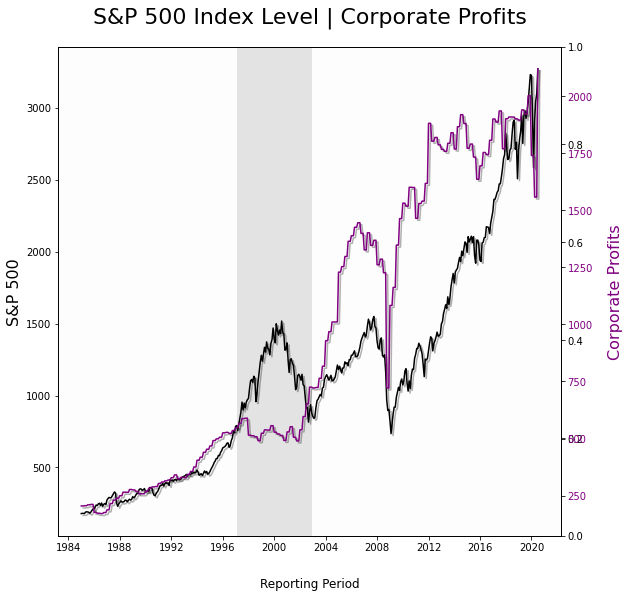

In [4]:
# SP500 versus Corporate Profits.
# Non-monotonic data

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_facecolor('xkcd:pale grey')
ax.set_title('S&P 500 Index Level | Corporate Profits',
             fontsize=22, pad=24)

ax.set_xlabel('Reporting Period', fontsize=12, labelpad=25)

ax.plot(df.index, df['sp500_close'], color='black', path_effects=
                    [path_effects.SimpleLineShadow(), path_effects.Normal()])
ax.set_ylabel('S&P 500', verticalalignment='bottom', fontsize=16) 
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2 = ax.twinx()

ax2.plot(df.index, df['corp_profits'], color='purple',
          path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
ax2.set_ylabel('Corporate Profits', color='purple', verticalalignment='top', 
               fontsize=16, labelpad=15)
ax2.tick_params(axis='y', labelcolor='purple')

ax.axvline(x=df.index[180], linewidth=75, color=(0,0,0,0.1))

plt.show()


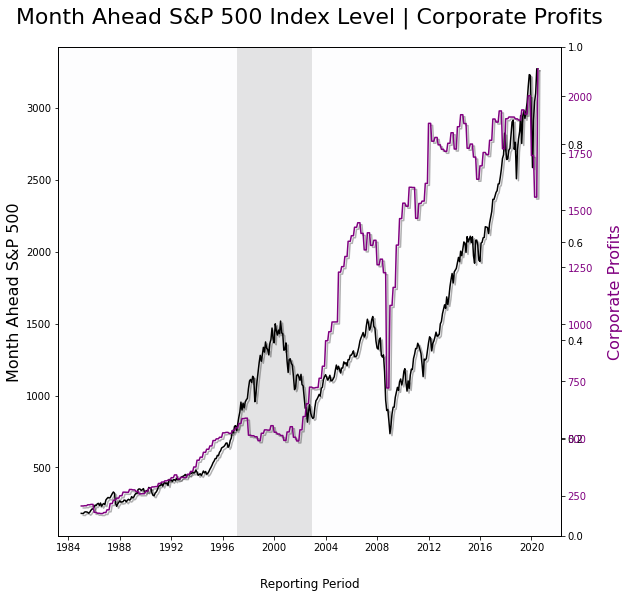

In [5]:
# SP500-month-ahead versus Corporate Profits.

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_facecolor('xkcd:pale grey')
ax.set_title('Month Ahead S&P 500 Index Level | Corporate Profits',
             fontsize=22, pad=24)

ax.set_xlabel('Reporting Period', fontsize=12, labelpad=25)

ax.plot(df.index, df['sp_ahead'], color='black', path_effects=
                    [path_effects.SimpleLineShadow(), path_effects.Normal()])
ax.set_ylabel('Month Ahead S&P 500', verticalalignment='bottom', fontsize=16) 
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2 = ax.twinx()

ax2.plot(df.index, df['corp_profits'], color='purple',
          path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
ax2.set_ylabel('Corporate Profits', color='purple', verticalalignment='top', 
               fontsize=16, labelpad=15)
ax2.tick_params(axis='y', labelcolor='purple')

ax.axvline(x=df.index[180], linewidth=75, color=(0,0,0,0.1))

plt.show()

In [6]:
for col in df.columns[:-4]:
    display(px.scatter(df, x=col, y='sp500_close', trendline='ols'))

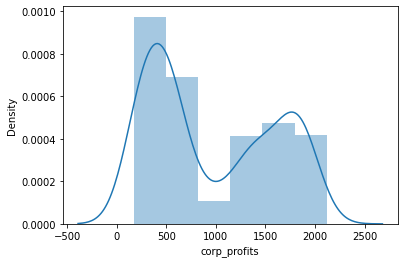

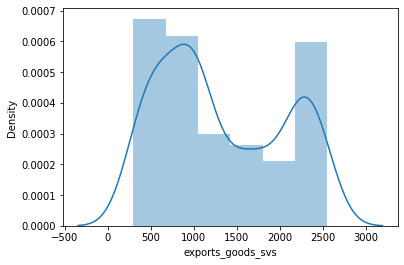

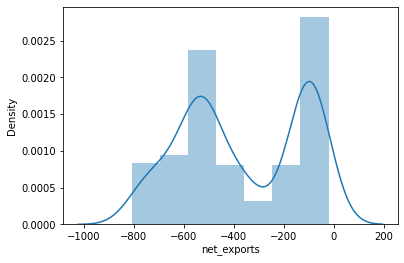

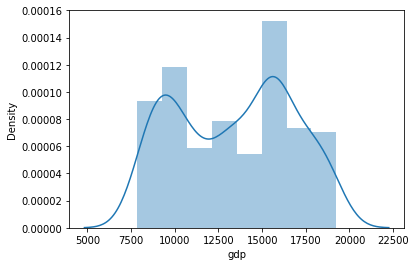

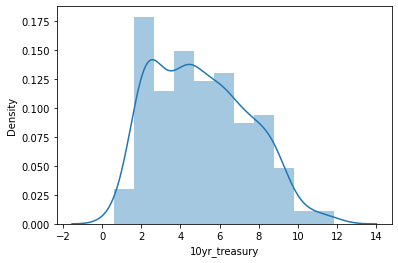

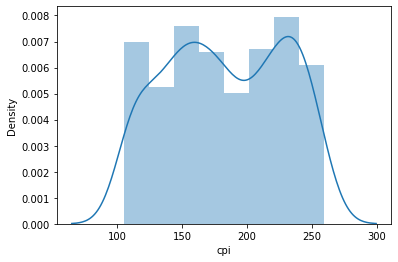

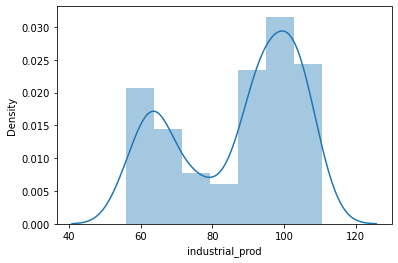

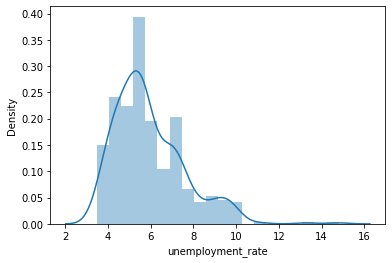

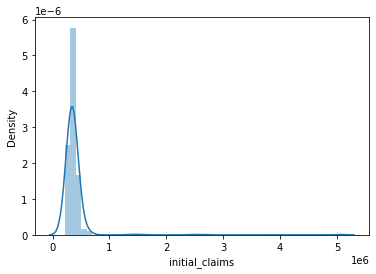

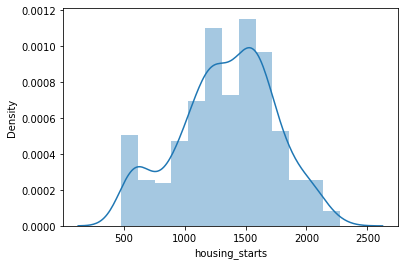

In [7]:
for col in df.columns[:-4]:
    sns.distplot(df[col])
    plt.show()

In [145]:
for col in df.columns[:-4]:
    display(px.scatter(df, x=col, y='sp_ahead', trendline='ols', opacity=0.1))

In [147]:
# Create a Feature Matrix and Target Vector
target = 'sp_ahead_pos_neg'

y = df[target]
X = df.drop(columns='sp_ahead_pos_neg')

print(X.shape, y.shape)

(427, 12) (427,)


In [148]:
# Split the data = create train and test sets 
# Will use 5-fold cross-validation with our training set

mask = df.index < '2014-01-01'

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(348, 12) (348,)
(79, 12) (79,)


In [149]:
# Let's look at the distribution of the target variable, 'sp_ahead_pos_neg', and determine our 
# majority class - the market has been up in the month ahead about 62.93% of the time.
# There is no gross overweighting of our classes, and we can use accuracy score to assess.
# We will also explore precision/recall and ROC-AUC curves for multiple models. 

baseline_outcomes = y_train.value_counts(normalize=True)*100
print(f'The majority class is True - "The Market Went Up"')
print(f'Our basline accuracy score is {baseline_outcomes[1]:.2f}%')

The majority class is True - "The Market Went Up"
Our basline accuracy score is 62.93%


In [17]:
# Logistic Regression 
model_lr = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [18]:
model_lr.score(X_train, y_train)

0.6494252873563219

In [21]:
# Random Forest Classifier 
model_rf = make_pipeline(
    SimpleImputer(strategy='mean'),
    RandomForestClassifier()
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [22]:
model_rf.score(X_train, y_train)

1.0

In [23]:
# Let's look at some interesting hyperparameters and tune the Logistic Regression model

estimator = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=22),
)

params = {'logisticregression__C': range(1, 21, 5),
          'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'logisticregression__max_iter': range(10, 201, 10)}

model_rs_lr = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_rs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(random_state=22))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'logisticregression__C': range(1, 21, 5),
                                        'logisticregression__max_iter': range(10, 201, 10),
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'liblinear',
                                                                       'sag',
                                                                     

In [24]:
model_rs_lr.best_params_

{'logisticregression__solver': 'liblinear',
 'logisticregression__max_iter': 190,
 'logisticregression__C': 11}

In [25]:
model_rs_lr.best_score_

0.6439337474120083

In [26]:
model_rs_lr.score(X_test, y_test)

0.6835443037974683

In [27]:
model_rc = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RidgeClassifier(random_state=22)
)

model_rc.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('ridgeclassifier', RidgeClassifier(random_state=22))])

In [28]:
model_rc.score(X_train, y_train)

0.6551724137931034

In [31]:
model_rc.score(X_test, y_test)

0.6835443037974683

In [29]:
coefficients = model_rc.named_steps['ridgeclassifier'].coef_
feature_names = X_train.columns

feature_importances = pd.Series(coefficients[0], index=feature_names)
feature_importances

corp_profits         0.792410
exports_goods_svs   -0.330985
net_exports          0.341377
gdp                 -0.275009
10yr_treasury       -0.218797
cpi                  0.149443
industrial_prod     -0.171130
unemployment_rate   -0.177108
initial_claims       0.130481
housing_starts       0.161547
dtype: float64

Text(0.5, 1.0, 'Feature Coefficients for Ridge Classifier model')

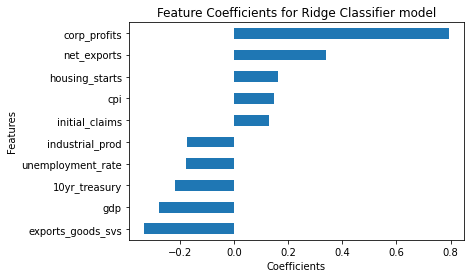

In [30]:
feature_importances.sort_values().plot(kind='barh')
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Feature Coefficients for Ridge Classifier model')

In [32]:
# Let's look at some interesting hyperparameters and tune the Ridge Classifier model

estimator = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RidgeClassifier(random_state=22),
)

params = {'ridgeclassifier__alpha': range(1, 102, 10)}

model_gs_rc = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_gs_rc.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('ridgeclassifier',
                                        RidgeClassifier(random_state=22))]),
             n_jobs=-1,
             param_grid={'ridgeclassifier__alpha': range(1, 102, 10)},
             verbose=1)

In [33]:
model_gs_rc.best_params_

{'ridgeclassifier__alpha': 1}

In [34]:
model_gs_rc.best_score_

0.62351966873706

In [35]:
model_gs_rc.score(X_test, y_test)

0.6835443037974683

In [31]:
model_gs_rc.estimator.named_steps['ridgeclassifier'].coef_

AttributeError: 'RidgeClassifier' object has no attribute 'coef_'

In [ ]:
country_grp = df.groupby(['Country'])
country_grp['LanguageWorkedWith'].str.contains('Python').sum()
country_uses_python = country_grp['LanguageWorkedWIth'].apply(lambda x: x.str.contains('Python').sum())
country_uses_python = country_grp['LanguafeWorkedWith'].apply(lambda x: x.str.contains('Python').sum())

pyton_df = pd.concat(['country_respondents', 'country_uses_python'], axis='columns', sort=False)

In [150]:
# model_XGBC = make_pipeline(
#     SimpleImputer(strategy='mean'),
#     XGBClassifier(max_depth=5, learning_rate=0.01, 
#                   n_estimators=2000, colsample_bytree=0.1,
#                   n_jobs=-1, random_state=22)
# )

# model_XGBC.fit(X_train, y_train)


imputer_object = SimpleImputer(strategy='mean')
X_train_imputed = imputer_object.fit_transform(X_train)
X_test_imputed = imputer_object.transform(X_test)


model_XGBC = XGBClassifier(max_depth=8, learning_rate=0.01, 
                  n_estimators=50, colsample_bytree=0.1,
                  n_jobs=-1, random_state=22)


model_XGBC.fit(X_train, y_train)

[18:08:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=-1, num_parallel_tree=1, random_state=22,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [151]:
model_XGBC.score(X_train, y_train)

0.7873563218390804

In [152]:
model_XGBC.score(X_test, y_test)

0.6835443037974683